In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
from torch.optim import AdamW
from torchvision.utils import save_image # For saving samples
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
from einops import rearrange
import matplotlib.pyplot as plt # For plotting if needed
import warnings
from typing import Tuple, Dict, Optional, List


# Mixed precision training
from torch.cuda.amp import GradScaler, autocast

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [ ]:
!pip install piq

In [ ]:
from torchvision import transforms
import torchvision.transforms.functional as TF
import random

class LOLv1Dataset(Dataset):
    """
    Dataset specifically for LOLv1 low-light image enhancement dataset
    """
    def __init__(self, root_dir, transform=None, high="target", low="input"):
        self.root_dir = root_dir
        self.transform = transform
        self.high_dir = os.path.join(root_dir, high)
        self.low_dir = os.path.join(root_dir, low)

        self.filenames = []
        if os.path.exists(self.low_dir):
            self.filenames = sorted(os.listdir(self.low_dir))
            valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}
            self.filenames = [f for f in self.filenames if os.path.splitext(f)[1].lower() in valid_extensions]
            self.filenames = [f for f in self.filenames if os.path.exists(os.path.join(self.high_dir, f))]
        else:
            print(f"Warning: Low light directory not found: {self.low_dir}")

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        filename = self.filenames[idx]
        low_img_path = os.path.join(self.low_dir, filename)
        high_img_path = os.path.join(self.high_dir, filename)

        try:
            low_img = Image.open(low_img_path).convert('RGB')
            high_img = Image.open(high_img_path).convert('RGB')
        except FileNotFoundError as e:
            print(f"Error loading image: {e}. Skipping this item.")
            # Return next valid item or raise error
            if len(self.filenames) > 1:
                 return self.__getitem__((idx + 1) % len(self.filenames))
            else:
                 raise RuntimeError(f"Could not load image {filename} and no other images available.")

        if self.transform:
            low_img = self.transform(low_img)
            high_img = self.transform(high_img)

        return {
            'low': low_img,
            'high': high_img,
            'filename': filename
        }

class AugmentedLOLV1Dataset(LOLv1Dataset):
    def __init__(self, root_dir, transform=None, augment=False, high="target", low="input"):
        super().__init__(root_dir, transform, high, low)
        self.augment = augment

    def __getitem__(self, idx):
        sample = super().__getitem__(idx)

        if self.augment:
            # Apply the same random transforms to both low and high images
            low_img, high_img = sample['low'], sample['high']

            # Convert to PIL for functional transforms
            low_img = TF.to_pil_image(low_img)
            high_img = TF.to_pil_image(high_img)

            # Random horizontal flip
            if random.random() > 0.5:
                low_img = TF.hflip(low_img)
                high_img = TF.hflip(high_img)

            # Random vertical flip
            if random.random() > 0.5:
                low_img = TF.vflip(low_img)
                high_img = TF.vflip(high_img)

            # Random rotation (±10 degrees)
            angle = random.uniform(-10, 10)
            low_img = TF.rotate(low_img, angle)
            high_img = TF.rotate(high_img, angle)

            # Random color jitter (brightness, contrast, saturation, hue)
            color_jitter = transforms.ColorJitter(
                brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)
            low_img = color_jitter(low_img)

            # Transform to tensor and normalize
            low_img = self.transform(low_img)
            high_img = self.transform(high_img)

            sample['low'] = low_img
            sample['high'] = high_img

        return sample


# VGG normalization (maps to ImageNet stats from [0,1] range)
vgg_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def custom_collate(batch):
    # Filter out None items that might result from loading errors
    batch = [b for b in batch if b is not None]
    if not batch:
        return None  # Or handle as an error

    low_imgs = torch.stack([item['low'] for item in batch])
    high_imgs = torch.stack([item['high'] for item in batch])
    filenames = [item['filename'] for item in batch]

    return {
        'low': low_imgs,
        'high': high_imgs,
        'filename': filenames
    }

def setup_data(batch_size=8, img_size=256, lolv1_base="/kaggle/input/lolv1-dataset/LOLv1"):
    # Transform without augmentation (for val/test)
    base_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

    # Augmented train dataset
    train_dataset_full = AugmentedLOLV1Dataset(
        root_dir=os.path.join(lolv1_base, "Train"),
        transform=base_transform,
        augment=True,
        high="target",
        low="input"
    )

    test_dataset = AugmentedLOLV1Dataset(
        root_dir=os.path.join(lolv1_base, "Test"),
        transform=base_transform,
        augment=False,
        high="target",
        low="input"
    )

    if len(train_dataset_full) == 0:
        raise ValueError("Training dataset is empty.")

    train_size = int(0.8 * len(train_dataset_full))
    val_size = len(train_dataset_full) - train_size

    if train_size == 0 or val_size == 0:
        val_dataset = train_dataset_full
    else:
        train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])
        # Disable augmentations in validation split
        val_dataset.dataset.augment = False

    print("Train Images:", len(train_dataset))
    print("Val Images:", len(val_dataset))
    print("Test Images:", len(test_dataset))

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              collate_fn=custom_collate, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            collate_fn=custom_collate, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             collate_fn=custom_collate, num_workers=0, pin_memory=True)

    return train_loader, val_loader, test_loader

Train Images: 388
Val Images: 97
Test Images: 15


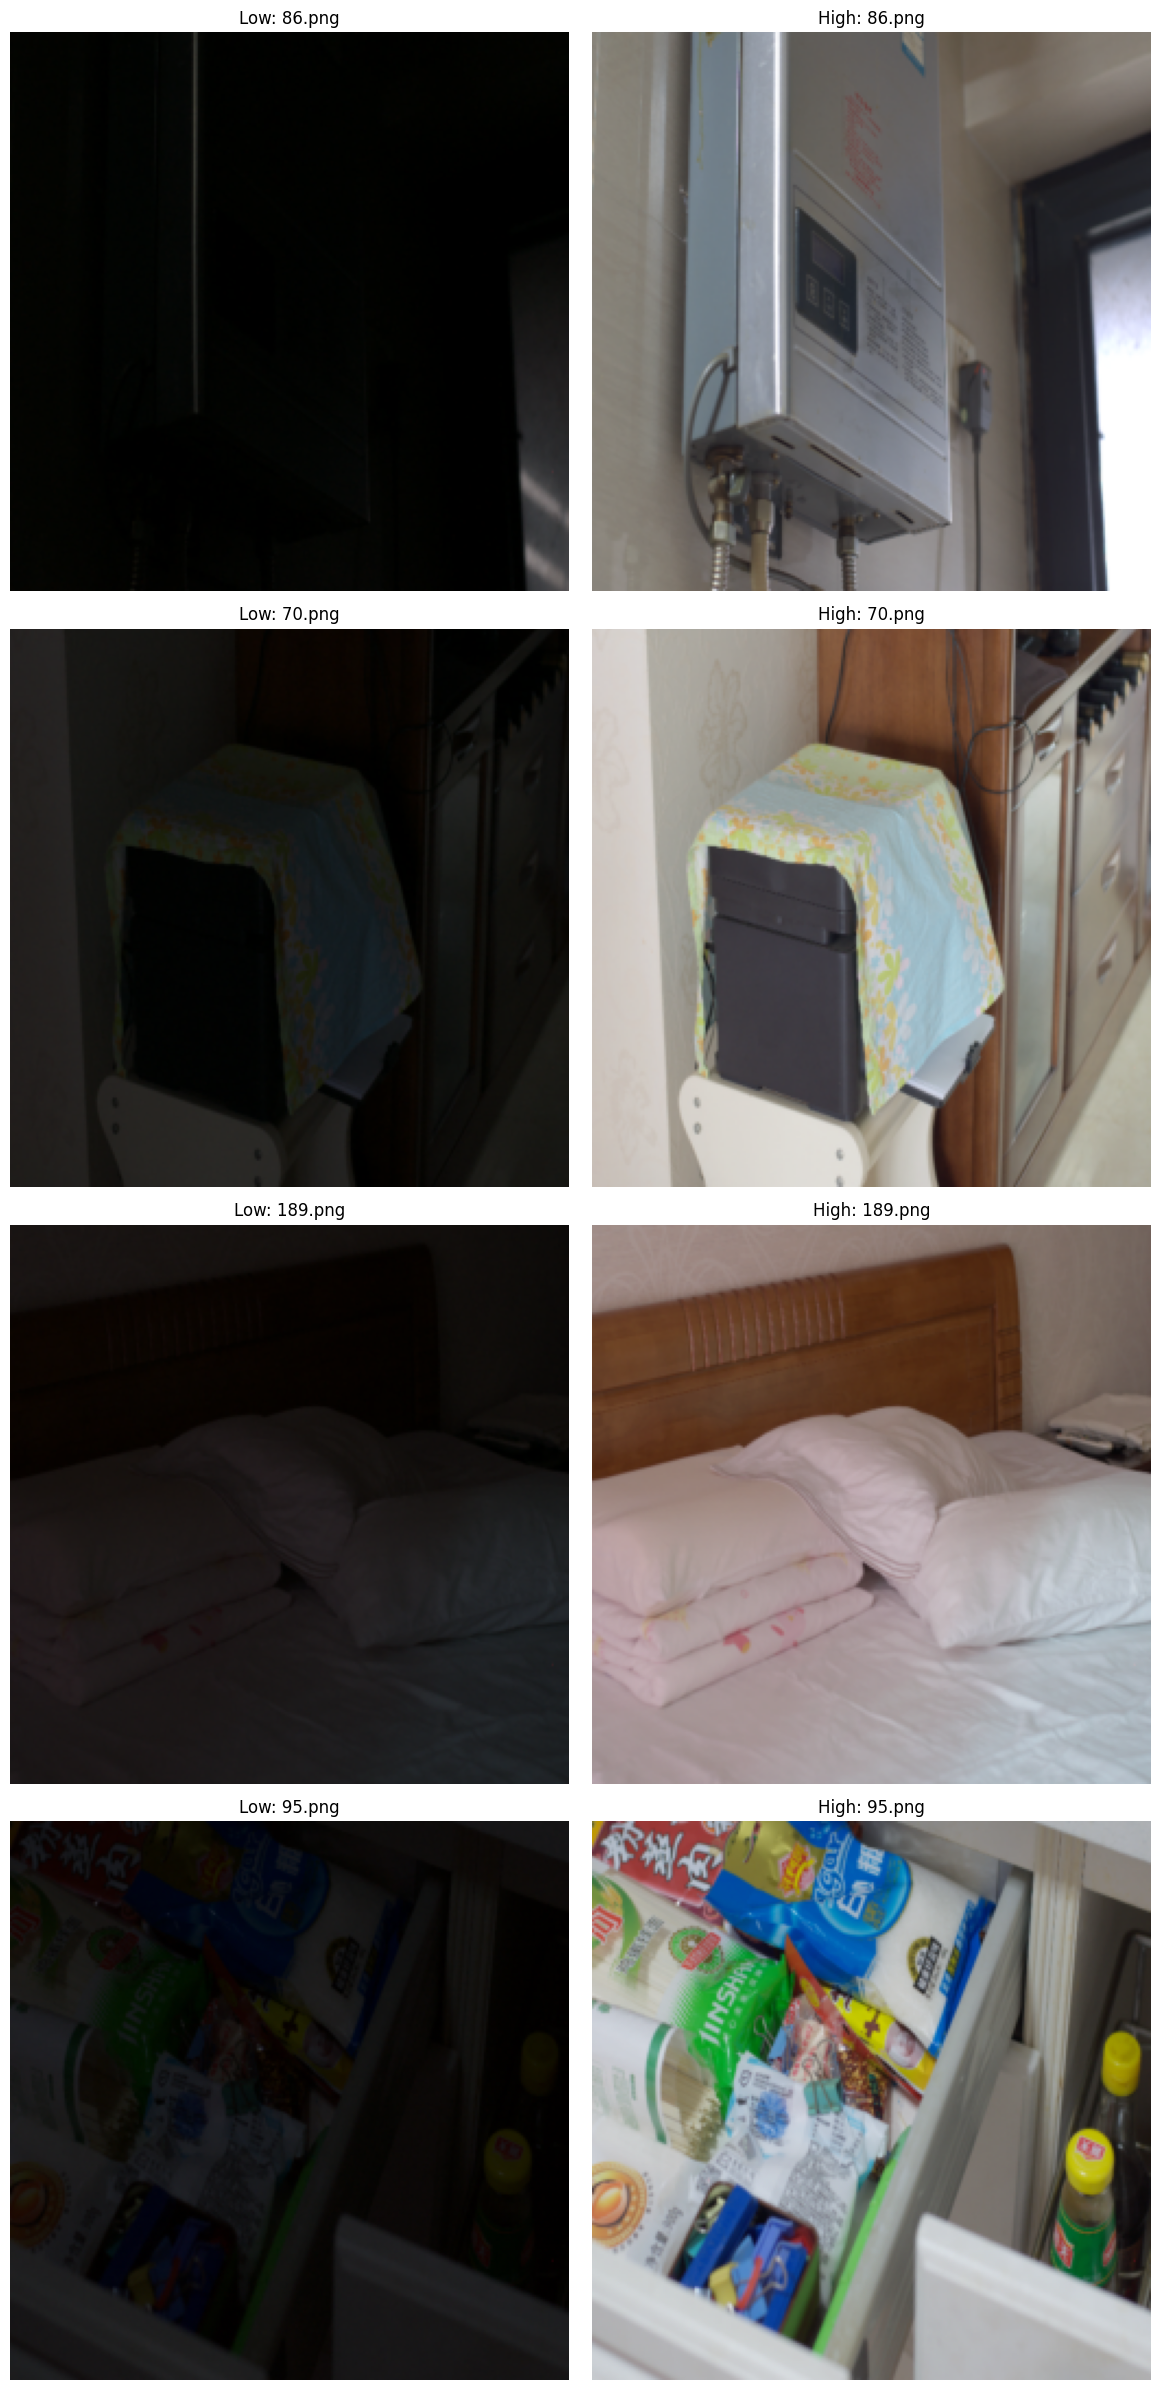

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def denormalize(tensor, mean=[0.5]*3, std=[0.5]*3):
    """Denormalize a tensor image with mean and std."""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp_(0, 1)

def visualize_batch(batch, nrows=4):
    """Visualize a batch of low/high image pairs."""
    low_imgs = batch['low']
    high_imgs = batch['high']
    filenames = batch['filename']

    ncols = 2  # low and high pairs
    nrows = min(nrows, len(low_imgs))

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6*nrows))
    if nrows == 1:
        axes = axes.reshape(1, -1)

    for i in range(nrows):
        # Denormalize and convert to numpy
        low = denormalize(low_imgs[i]).permute(1, 2, 0).numpy()
        high = denormalize(high_imgs[i]).permute(1, 2, 0).numpy()

        # Plot low-light image
        axes[i, 0].imshow(low)
        axes[i, 0].set_title(f"Low: {filenames[i]}")
        axes[i, 0].axis('off')

        # Plot high-light image
        axes[i, 1].imshow(high)
        axes[i, 1].set_title(f"High: {filenames[i]}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Get a batch from the training loader
train_loader, val_loader, test_loader = setup_data()
batch = next(iter(train_loader))

# Visualize the batch
visualize_batch(batch)

# MOdel

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16
from torch.cuda.amp import autocast

class FrequencyDomainProcessing(nn.Module):
    """Fixed frequency domain processing block"""
    def __init__(self, channels):
        super().__init__()
        self.channels = channels

    def forward(self, x):
        # Get frequency representation using FFT
        bs, c, h, w = x.shape

        # Apply 2D FFT
        dct_coeff = torch.fft.rfft2(x, norm='ortho')

        # Process real and imaginary parts separately
        real = dct_coeff.real
        imag = dct_coeff.imag

        # Stack along channel dimension - this ensures we maintain 4D shape
        freq = torch.cat([real, imag], dim=1)  # [B, 2*C, H, W//2+1]

        # Pad to maintain original spatial dimensions if needed
        if freq.shape[-1] != w:
            pad_width = w - freq.shape[-1]
            freq = F.pad(freq, (0, pad_width))

        # Project back to original channel dimension
        freq_proj = nn.Conv2d(freq.shape[1], c, 1, device=x.device)(freq)

        # Combine with input
        return freq_proj + x

class SelfSupervisedAttention(nn.Module):
    """Fixed self-supervised attention mechanism"""
    def __init__(self, channels):
        super().__init__()
        self.query = nn.Conv2d(channels, channels//8, 1)
        self.key = nn.Conv2d(channels, channels//8, 1)
        self.value = nn.Conv2d(channels, channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        bs, c, h, w = x.shape

        # Ensure we maintain 4D tensors throughout
        query = self.query(x).view(bs, -1, h*w).permute(0, 2, 1)  # [B, HW, C//8]
        key = self.key(x).view(bs, -1, h*w)  # [B, C//8, HW]

        # Compute attention
        energy = torch.bmm(query, key)  # [B, HW, HW]
        attention = F.softmax(energy, dim=-1)

        value = self.value(x).view(bs, -1, h*w)  # [B, C, HW]
        out = torch.bmm(value, attention.permute(0, 2, 1))  # [B, C, HW]
        out = out.view(bs, c, h, w)  # Back to [B, C, H, W]

        return self.gamma * out + x

class AdaptiveContrastBlock(nn.Module):
    """Fixed adaptive contrast learning block"""
    def __init__(self, channels):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels//4, 1),
            nn.ReLU(),
            nn.Conv2d(channels//4, 3, 1),  # Predict 3 params (scale, shift, gamma)
            nn.Sigmoid()
        )

    def forward(self, x):
        # Ensure input is 4D
        if x.dim() != 4:
            raise ValueError(f"Expected 4D input, got {x.dim()}D with shape {x.shape}")

        params = self.conv(self.avg_pool(x))  # [B, 3, 1, 1]

        # Extract parameters and ensure proper broadcasting
        scale = params[:, 0:1] * 2  # [B, 1, 1, 1] - range [0,2]
        shift = (params[:, 1:2] * 2 - 1)  # [B, 1, 1, 1] - range [-1,1]
        gamma = params[:, 2:3] * 2  # [B, 1, 1, 1] - range [0,2]

        # Apply adaptive contrast
        mean = torch.mean(x, dim=(2,3), keepdim=True)
        var = torch.var(x, dim=(2,3), keepdim=True)
        normalized = (x - mean) / (torch.sqrt(var) + 1e-5)
        enhanced = normalized * scale + shift

        return torch.sigmoid(gamma) * enhanced + (1 - torch.sigmoid(gamma)) * x

class ResidualDenseBlock(nn.Module):
    """Fixed residual dense block"""
    def __init__(self, channels, growth_rate=32):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, growth_rate, 3, padding=1)
        self.conv2 = nn.Conv2d(channels + growth_rate, growth_rate, 3, padding=1)
        self.conv3 = nn.Conv2d(channels + 2*growth_rate, growth_rate, 3, padding=1)
        self.conv4 = nn.Conv2d(channels + 3*growth_rate, growth_rate, 3, padding=1)
        self.conv5 = nn.Conv2d(channels + 4*growth_rate, channels, 3, padding=1)
        self.attention = SelfSupervisedAttention(channels)

    def forward(self, x):
        # Ensure input is 4D
        if x.dim() != 4:
            raise ValueError(f"Expected 4D input, got {x.dim()}D with shape {x.shape}")

        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(torch.cat([x, x1], 1)))
        x3 = F.relu(self.conv3(torch.cat([x, x1, x2], 1)))
        x4 = F.relu(self.conv4(torch.cat([x, x1, x2, x3], 1)))
        x5 = self.conv5(torch.cat([x, x1, x2, x3, x4], 1))

        # Add residual connection and apply attention
        residual = x + x5
        return self.attention(residual)

class DualPathGenerator(nn.Module):
    """Fixed generator with proper dimension handling"""
    def __init__(self, in_channels=3, out_channels=3, base_channels=64):
        super().__init__()

        # Downsampling path
        self.down1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 4, 2, 1),
            nn.LeakyReLU(0.2)
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels*2, 4, 2, 1),
            nn.InstanceNorm2d(base_channels*2),
            nn.LeakyReLU(0.2)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels*4, 4, 2, 1),
            nn.InstanceNorm2d(base_channels*4),
            nn.LeakyReLU(0.2)
        )

        # Processing blocks - simplified frequency processing
        self.resnet_blocks = nn.Sequential(
            *[ResidualDenseBlock(base_channels*4) for _ in range(4)]
        )
        # Remove problematic frequency block for now
        # self.freq_block = FrequencyDomainProcessing(base_channels*4)
        self.contrast_block = AdaptiveContrastBlock(base_channels*4)

        # Additional processing conv to ensure proper feature extraction
        self.feature_conv = nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1)

        # Upsampling path - fixed channel dimensions
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*8, base_channels*2, 4, 2, 1),  # Input: 512, Output: 128
            nn.InstanceNorm2d(base_channels*2),
            nn.ReLU()
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*4, base_channels, 4, 2, 1),   # Input: 256, Output: 64
            nn.InstanceNorm2d(base_channels),
            nn.ReLU()
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*2, out_channels, 4, 2, 1),    # Input: 128, Output: 3
            nn.Tanh()
        )

    def forward(self, x):
        # Debug: Print input shape
        if x.dim() != 4:
            raise ValueError(f"Expected 4D input, got {x.dim()}D with shape {x.shape}")

        # Downsample
        d1 = self.down1(x)      # [B, 64, H/2, W/2]
        d2 = self.down2(d1)     # [B, 128, H/4, W/4]
        d3 = self.down3(d2)     # [B, 256, H/8, W/8]

        # Process - ensure all outputs are 4D
        res_out = self.resnet_blocks(d3)     # [B, 256, H/8, W/8]
        contrast_out = self.contrast_block(res_out)  # [B, 256, H/8, W/8]
        processed = self.feature_conv(contrast_out)  # [B, 256, H/8, W/8]

        # Debug: Check dimensions before concatenation
        if processed.dim() != 4 or d3.dim() != 4:
            raise ValueError(f"Dimension mismatch: processed={processed.shape}, d3={d3.shape}")

        # Upsample with skip connections
        u1_input = torch.cat([processed, d3], dim=1)  # [B, 512, H/8, W/8]
        u1 = self.up1(u1_input)  # [B, 128, H/4, W/4]

        u2_input = torch.cat([u1, d2], dim=1)  # [B, 256, H/4, W/4]
        u2 = self.up2(u2_input)  # [B, 64, H/2, W/2]

        u3_input = torch.cat([u2, d1], dim=1)  # [B, 128, H/2, W/2]
        u3 = self.up3(u3_input)  # [B, 3, H, W]

        return u3

class MultiScaleDiscriminator(nn.Module):
    """Simplified discriminator without frequency processing for now"""
    def __init__(self, in_channels=3, base_channels=64):
        super().__init__()

        # Main discriminator path
        self.conv1 = nn.Conv2d(in_channels, base_channels, 4, 2, 1)
        self.conv2 = nn.Conv2d(base_channels, base_channels*2, 4, 2, 1)
        self.conv3 = nn.Conv2d(base_channels*2, base_channels*4, 4, 2, 1)
        self.conv4 = nn.Conv2d(base_channels*4, base_channels*8, 4, 2, 1)
        self.conv5 = nn.Conv2d(base_channels*8, 1, 4, 1, 1)

        self.leaky_relu = nn.LeakyReLU(0.2)
        self.instance_norm2 = nn.InstanceNorm2d(base_channels*2)
        self.instance_norm4 = nn.InstanceNorm2d(base_channels*4)
        self.instance_norm8 = nn.InstanceNorm2d(base_channels*8)

    def forward(self, x):
        # Ensure input is 4D
        if x.dim() != 4:
            raise ValueError(f"Expected 4D input, got {x.dim()}D with shape {x.shape}")

        # Main spatial path
        h1 = self.leaky_relu(self.conv1(x))
        h2 = self.leaky_relu(self.instance_norm2(self.conv2(h1)))
        h3 = self.leaky_relu(self.instance_norm4(self.conv3(h2)))
        h4 = self.leaky_relu(self.instance_norm8(self.conv4(h3)))
        h5 = self.conv5(h4)

        # Return prediction and feature maps
        return h5, [h1, h2, h3, h4], []

class LowLightGAN(nn.Module):
    """Fixed GAN model for low-light enhancement with stability improvements"""
    def __init__(self, device='cuda'):
        super().__init__()
        self.generator = DualPathGenerator().to(device)
        self.discriminator = MultiScaleDiscriminator().to(device)
        self.device = device

        # Initialize weights properly
        self.generator.apply(self._init_weights)
        self.discriminator.apply(self._init_weights)

        # VGG for perceptual loss
        self.vgg = vgg16(pretrained=True).features[:16].to(device)
        for param in self.vgg.parameters():
            param.requires_grad = False

        # Loss functions
        self.l1_loss = nn.L1Loss()
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def _init_weights(self, m):
        """Initialize weights with Xavier/He initialization"""
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.InstanceNorm2d, nn.BatchNorm2d)):
            if m.weight is not None:
                nn.init.constant_(m.weight, 1)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.generator(x)

    def adversarial_loss(self, real_pred, fake_pred):
        real_loss = self.bce_loss(real_pred, torch.ones_like(real_pred))
        fake_loss = self.bce_loss(fake_pred, torch.zeros_like(fake_pred))
        return (real_loss + fake_loss) / 2

    def perceptual_loss(self, real, fake):
        # Ensure inputs are in the right range for VGG and handle NaN
        try:
            real_norm = torch.clamp((real + 1) / 2, 0, 1)  # Convert from [-1,1] to [0,1]
            fake_norm = torch.clamp((fake + 1) / 2, 0, 1)

            # Check for NaN
            if torch.isnan(real_norm).any() or torch.isnan(fake_norm).any():
                return torch.tensor(0.0, device=self.device, requires_grad=True)

            real_feats = self.vgg(real_norm)
            fake_feats = self.vgg(fake_norm)

            loss = self.l1_loss(real_feats, fake_feats)

            # Additional NaN check
            if torch.isnan(loss):
                return torch.tensor(0.0, device=self.device, requires_grad=True)

            return loss
        except Exception as e:
            print(f"Error in perceptual loss: {e}")
            return torch.tensor(0.0, device=self.device, requires_grad=True)

    def gradient_loss(self, real, fake):
        # Multi-scale gradient loss with NaN protection
        try:
            loss = 0
            valid_scales = 0

            for scale in [1, 2, 4]:
                try:
                    real_down = F.avg_pool2d(real, scale) if scale > 1 else real
                    fake_down = F.avg_pool2d(fake, scale) if scale > 1 else fake

                    # Clamp values to prevent extreme gradients
                    real_down = torch.clamp(real_down, -3, 3)
                    fake_down = torch.clamp(fake_down, -3, 3)

                    real_grad_x = torch.abs(real_down[:, :, :, 1:] - real_down[:, :, :, :-1])
                    real_grad_y = torch.abs(real_down[:, :, 1:, :] - real_down[:, :, :-1, :])

                    fake_grad_x = torch.abs(fake_down[:, :, :, 1:] - fake_down[:, :, :, :-1])
                    fake_grad_y = torch.abs(fake_down[:, :, 1:, :] - fake_down[:, :, :-1, :])

                    scale_loss = self.l1_loss(real_grad_x, fake_grad_x) + self.l1_loss(real_grad_y, fake_grad_y)

                    if not torch.isnan(scale_loss):
                        loss += scale_loss
                        valid_scales += 1

                except Exception as e:
                    print(f"Error in gradient loss scale {scale}: {e}")
                    continue

            if valid_scales > 0:
                return loss / valid_scales
            else:
                return torch.tensor(0.0, device=self.device, requires_grad=True)

        except Exception as e:
            print(f"Error in gradient loss: {e}")
            return torch.tensor(0.0, device=self.device, requires_grad=True)

    def train_step(self, low_imgs, high_imgs, optimizer_G, optimizer_D):
        # Move to device and ensure proper dimensions
        low_imgs = low_imgs.to(self.device)
        high_imgs = high_imgs.to(self.device)

        # Debug: Check input dimensions
        if low_imgs.dim() != 4 or high_imgs.dim() != 4:
            raise ValueError(f"Expected 4D tensors, got low_imgs: {low_imgs.shape}, high_imgs: {high_imgs.shape}")

        # Generate enhanced images
        enhanced_imgs = self.generator(low_imgs)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real images
        real_pred, real_spatial_feats, real_freq_feats = self.discriminator(high_imgs)
        # Fake images
        fake_pred, fake_spatial_feats, fake_freq_feats = self.discriminator(enhanced_imgs.detach())

        # Discriminator loss
        d_loss = self.adversarial_loss(real_pred, fake_pred)

        # Feature matching loss (only spatial features for now)
        feat_loss = 0
        for real_feat, fake_feat in zip(real_spatial_feats, fake_spatial_feats):
            feat_loss += self.l1_loss(real_feat, fake_feat)
        d_loss += feat_loss * 0.1

        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generator adversarial loss
        fake_pred, _, _ = self.discriminator(enhanced_imgs)
        g_adv_loss = self.bce_loss(fake_pred, torch.ones_like(fake_pred))

        # Reconstruction losses
        l1_loss = self.l1_loss(enhanced_imgs, high_imgs) * 10
        perceptual_loss = self.perceptual_loss(high_imgs, enhanced_imgs) * 0.1
        gradient_loss = self.gradient_loss(high_imgs, enhanced_imgs) * 5

        # Total generator loss
        g_loss = g_adv_loss + l1_loss + perceptual_loss + gradient_loss
        g_loss.backward()
        optimizer_G.step()

        return {
            'd_loss': d_loss.item(),
            'g_loss': g_loss.item(),
            'g_adv': g_adv_loss.item(),
            'l1': l1_loss.item(),
            'perceptual': perceptual_loss.item(),
            'gradient': gradient_loss.item()
        }

    def enhance(self, low_imgs):
        """Enhance low-light images"""
        self.eval()
        with torch.no_grad():
            enhanced = self.generator(low_imgs.to(self.device))
        self.train()
        return enhanced.clamp(-1, 1) * 0.5 + 0.5  # Convert from [-1,1] to [0,1]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler
import numpy as np
from math import log10
from piq import psnr, ssim, LPIPS
import time
import os
from tqdm import tqdm
import warnings

class Trainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device

        # More conservative optimizers with lower learning rates
        self.optimizer_G = optim.Adam(
            model.generator.parameters(),
            lr=1e-4,  # Reduced from 2e-4
            betas=(0.5, 0.999),
            weight_decay=1e-6  # Added weight decay for stability
        )
        self.optimizer_D = optim.Adam(
            model.discriminator.parameters(),
            lr=5e-5,  # Reduced from 1e-4
            betas=(0.5, 0.999),
            weight_decay=1e-6
        )

        # Learning rate schedulers with warmup
        self.scheduler_G = CosineAnnealingLR(self.optimizer_G, T_max=100, eta_min=1e-7)
        self.scheduler_D = CosineAnnealingLR(self.optimizer_D, T_max=100, eta_min=5e-8)

        # Loss metrics
        self.lpips = LPIPS().to(device)

        # Mixed precision training with conservative settings
        self.scaler = GradScaler(init_scale=2.**8)  # Lower initial scale

        # Gradient clipping values
        self.max_grad_norm = 1.0

        # Logging
        self.best_psnr = 0
        self.train_losses = {'g_loss': [], 'd_loss': [], 'l1': [], 'perceptual': [], 'gradient': []}
        self.val_metrics = {'psnr': [], 'ssim': [], 'lpips': []}

        # NaN detection and recovery
        self.nan_count = 0
        self.max_nan_tolerance = 3

    def check_for_nan(self, tensor, name="tensor"):
        """Check for NaN values and return True if found"""
        if torch.isnan(tensor).any():
            print(f"WARNING: NaN detected in {name}")
            return True
        return False

    def reset_optimizers_on_nan(self):
        """Reset optimizers when NaN is detected"""
        print("Resetting optimizers due to NaN values...")
        self.optimizer_G.zero_grad()
        self.optimizer_D.zero_grad()

        # Reinitialize optimizers with even lower learning rates
        for param_group in self.optimizer_G.param_groups:
            param_group['lr'] *= 0.5
        for param_group in self.optimizer_D.param_groups:
            param_group['lr'] *= 0.5

    def train_epoch(self, epoch):
        self.model.train()
        progress_bar = tqdm(self.train_loader, desc=f'Training Epoch {epoch}')

        epoch_losses = {'g_loss': [], 'd_loss': [], 'l1': [], 'perceptual': [], 'gradient': []}

        for batch_idx, batch in enumerate(progress_bar):
            try:
                low_imgs = batch['low'].to(self.device)
                high_imgs = batch['high'].to(self.device)

                # Check input for NaN
                if self.check_for_nan(low_imgs, "low_imgs") or self.check_for_nan(high_imgs, "high_imgs"):
                    print(f"Skipping batch {batch_idx} due to NaN in input")
                    continue

                # Clamp inputs to reasonable range
                low_imgs = torch.clamp(low_imgs, -3, 3)
                high_imgs = torch.clamp(high_imgs, -3, 3)

                # Train step with error handling
                losses = self.stable_train_step(low_imgs, high_imgs)

                # Check for NaN in losses
                nan_detected = False
                for key, value in losses.items():
                    if np.isnan(value) or np.isinf(value):
                        print(f"NaN/Inf detected in {key}: {value}")
                        nan_detected = True
                        break

                if nan_detected:
                    self.nan_count += 1
                    if self.nan_count > self.max_nan_tolerance:
                        print("Too many NaN occurrences, stopping training")
                        return

                    self.reset_optimizers_on_nan()
                    continue

                # Reset NaN count on successful iteration
                self.nan_count = 0

                # Update progress bar
                progress_bar.set_postfix({
                    'G Loss': f"{losses['g_loss']:.4f}",
                    'D Loss': f"{losses['d_loss']:.4f}",
                    'L1': f"{losses['l1']:.4f}"
                })

                # Log losses
                for key in losses:
                    if key in epoch_losses:
                        epoch_losses[key].append(losses[key])

            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                continue

        # Update learning rates
        self.scheduler_G.step()
        self.scheduler_D.step()

        # Store epoch averages
        for key in epoch_losses:
            if epoch_losses[key]:  # Only if we have valid losses
                avg_loss = np.mean(epoch_losses[key])
                self.train_losses[key].append(avg_loss)

    def stable_train_step(self, low_imgs, high_imgs):
        """Stable training step with gradient clipping and NaN checking"""

        # Generate enhanced images
        enhanced_imgs = self.model.generator(low_imgs)

        # Check generator output
        if self.check_for_nan(enhanced_imgs, "enhanced_imgs"):
            # Return dummy losses to continue
            return {
                'd_loss': 0.0, 'g_loss': 0.0, 'g_adv': 0.0,
                'l1': 0.0, 'perceptual': 0.0, 'gradient': 0.0
            }

        # Clamp enhanced images
        enhanced_imgs = torch.clamp(enhanced_imgs, -3, 3)

        # Train Discriminator
        self.optimizer_D.zero_grad()

        # Real images
        real_pred, real_spatial_feats, real_freq_feats = self.model.discriminator(high_imgs)
        # Fake images
        fake_pred, fake_spatial_feats, fake_freq_feats = self.model.discriminator(enhanced_imgs.detach())

        # Discriminator loss with label smoothing
        real_labels = torch.ones_like(real_pred) * 0.9  # Label smoothing
        fake_labels = torch.zeros_like(fake_pred) + 0.1

        real_loss = self.model.bce_loss(real_pred, real_labels)
        fake_loss = self.model.bce_loss(fake_pred, fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        # Feature matching loss
        feat_loss = 0
        for real_feat, fake_feat in zip(real_spatial_feats, fake_spatial_feats):
            feat_loss += self.model.l1_loss(real_feat, fake_feat)
        d_loss += feat_loss * 0.1

        # Check discriminator loss
        if not self.check_for_nan(d_loss, "d_loss"):
            d_loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.discriminator.parameters(), self.max_grad_norm)

            self.optimizer_D.step()

        # Train Generator
        self.optimizer_G.zero_grad()

        # Generator adversarial loss
        fake_pred, _, _ = self.model.discriminator(enhanced_imgs)
        g_adv_loss = self.model.bce_loss(fake_pred, torch.ones_like(fake_pred))

        # Reconstruction losses with reduced weights
        l1_loss = self.model.l1_loss(enhanced_imgs, high_imgs) * 5  # Reduced from 10

        # Safe perceptual loss calculation
        try:
            perceptual_loss = self.model.perceptual_loss(high_imgs, enhanced_imgs) * 0.05  # Reduced from 0.1
        except:
            perceptual_loss = torch.tensor(0.0, device=self.device)

        # Safe gradient loss calculation
        try:
            gradient_loss = self.model.gradient_loss(high_imgs, enhanced_imgs) * 2  # Reduced from 5
        except:
            gradient_loss = torch.tensor(0.0, device=self.device)

        # Total generator loss
        g_loss = g_adv_loss + l1_loss + perceptual_loss + gradient_loss

        # Check generator loss
        if not self.check_for_nan(g_loss, "g_loss"):
            g_loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.generator.parameters(), self.max_grad_norm)

            self.optimizer_G.step()

        return {
            'd_loss': d_loss.item() if not torch.isnan(d_loss) else 0.0,
            'g_loss': g_loss.item() if not torch.isnan(g_loss) else 0.0,
            'g_adv': g_adv_loss.item() if not torch.isnan(g_adv_loss) else 0.0,
            'l1': l1_loss.item() if not torch.isnan(l1_loss) else 0.0,
            'perceptual': perceptual_loss.item() if not torch.isnan(perceptual_loss) else 0.0,
            'gradient': gradient_loss.item() if not torch.isnan(gradient_loss) else 0.0
        }

    @torch.no_grad()
    def validate(self, epoch):
        self.model.eval()
        total_psnr = 0
        total_ssim = 0
        total_lpips = 0
        num_samples = 0
        valid_samples = 0

        progress_bar = tqdm(self.val_loader, desc=f'Validation Epoch {epoch}')

        for batch in progress_bar:
            try:
                low_imgs = batch['low'].to(self.device)
                high_imgs = batch['high'].to(self.device)

                # Check for NaN in inputs
                if self.check_for_nan(low_imgs, "val_low_imgs") or self.check_for_nan(high_imgs, "val_high_imgs"):
                    continue

                # Generate enhanced images
                enhanced_imgs = self.model.enhance(low_imgs)

                # Check for NaN in output
                if self.check_for_nan(enhanced_imgs, "val_enhanced_imgs"):
                    continue

                # Clamp outputs to valid range
                enhanced_imgs = torch.clamp(enhanced_imgs, 0, 1)

                # Convert from [-1,1] to [0,1] range for high_imgs
                high_imgs = torch.clamp((high_imgs * 0.5) + 0.5, 0, 1)

                # Calculate metrics with error handling
                try:
                    batch_psnr = psnr(enhanced_imgs, high_imgs, data_range=1.0, reduction='mean')
                    batch_ssim = ssim(enhanced_imgs, high_imgs, data_range=1.0, reduction='mean')
                    batch_lpips = self.lpips(enhanced_imgs, high_imgs)

                    # Check for valid metrics
                    if not (torch.isnan(batch_psnr) or torch.isnan(batch_ssim) or torch.isnan(batch_lpips)):
                        total_psnr += batch_psnr.item() * low_imgs.size(0)
                        total_ssim += batch_ssim.item() * low_imgs.size(0)
                        total_lpips += batch_lpips.item() * low_imgs.size(0)
                        valid_samples += low_imgs.size(0)

                except Exception as e:
                    print(f"Error calculating metrics: {e}")
                    continue

                num_samples += low_imgs.size(0)

                if valid_samples > 0:
                    progress_bar.set_postfix({
                        'PSNR': total_psnr / valid_samples,
                        'SSIM': total_ssim / valid_samples,
                        'LPIPS': total_lpips / valid_samples
                    })

            except Exception as e:
                print(f"Error in validation batch: {e}")
                continue

        # Calculate average metrics
        if valid_samples > 0:
            avg_psnr = total_psnr / valid_samples
            avg_ssim = total_ssim / valid_samples
            avg_lpips = total_lpips / valid_samples
        else:
            print("No valid samples in validation!")
            avg_psnr = avg_ssim = avg_lpips = 0.0

        # Log metrics
        self.val_metrics['psnr'].append(avg_psnr)
        self.val_metrics['ssim'].append(avg_ssim)
        self.val_metrics['lpips'].append(avg_lpips)

        # Save best model
        if avg_psnr > self.best_psnr:
            self.best_psnr = avg_psnr
            self.save_checkpoint(epoch, is_best=True)

        return avg_psnr, avg_ssim, avg_lpips

    @torch.no_grad()
    def test(self):
        self.model.eval()
        total_psnr = 0
        total_ssim = 0
        total_lpips = 0
        valid_samples = 0

        progress_bar = tqdm(self.test_loader, desc='Testing')

        for batch in progress_bar:
            try:
                low_imgs = batch['low'].to(self.device)
                high_imgs = batch['high'].to(self.device)

                # Check for NaN in inputs
                if self.check_for_nan(low_imgs, "test_low_imgs") or self.check_for_nan(high_imgs, "test_high_imgs"):
                    continue

                # Generate enhanced images
                enhanced_imgs = self.model.enhance(low_imgs)

                # Check for NaN in output
                if self.check_for_nan(enhanced_imgs, "test_enhanced_imgs"):
                    continue

                # Clamp outputs to valid range
                enhanced_imgs = torch.clamp(enhanced_imgs, 0, 1)
                high_imgs = torch.clamp((high_imgs * 0.5) + 0.5, 0, 1)

                # Calculate metrics
                try:
                    batch_psnr = psnr(enhanced_imgs, high_imgs, data_range=1.0, reduction='mean')
                    batch_ssim = ssim(enhanced_imgs, high_imgs, data_range=1.0, reduction='mean')
                    batch_lpips = self.lpips(enhanced_imgs, high_imgs)

                    if not (torch.isnan(batch_psnr) or torch.isnan(batch_ssim) or torch.isnan(batch_lpips)):
                        total_psnr += batch_psnr.item() * low_imgs.size(0)
                        total_ssim += batch_ssim.item() * low_imgs.size(0)
                        total_lpips += batch_lpips.item() * low_imgs.size(0)
                        valid_samples += low_imgs.size(0)

                except Exception as e:
                    print(f"Error calculating test metrics: {e}")
                    continue

                if valid_samples > 0:
                    progress_bar.set_postfix({
                        'PSNR': total_psnr / valid_samples,
                        'SSIM': total_ssim / valid_samples,
                        'LPIPS': total_lpips / valid_samples
                    })

            except Exception as e:
                print(f"Error in test batch: {e}")
                continue

        # Calculate average metrics
        if valid_samples > 0:
            avg_psnr = total_psnr / valid_samples
            avg_ssim = total_ssim / valid_samples
            avg_lpips = total_lpips / valid_samples

            print(f"\nTest Results - PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}, LPIPS: {avg_lpips:.4f}")
        else:
            print("No valid samples in test set!")
            avg_psnr = avg_ssim = avg_lpips = 0.0

        return avg_psnr, avg_ssim, avg_lpips

    def save_checkpoint(self, epoch, is_best=False):
        state = {
            'epoch': epoch,
            'model_state': self.model.state_dict(),
            'optimizer_G_state': self.optimizer_G.state_dict(),
            'optimizer_D_state': self.optimizer_D.state_dict(),
            'scheduler_G_state': self.scheduler_G.state_dict(),
            'scheduler_D_state': self.scheduler_D.state_dict(),
            'best_psnr': self.best_psnr,
            'train_losses': self.train_losses,
            'val_metrics': self.val_metrics
        }

        if not os.path.exists('checkpoints'):
            os.makedirs('checkpoints')

        filename = f'checkpoints/epoch_{epoch}.pth'
        torch.save(state, filename)

        if is_best:
            best_filename = 'checkpoints/best_model.pth'
            torch.save(state, best_filename)
            print(f"Saved best model with PSNR: {self.best_psnr:.2f}")

    def load_checkpoint(self, checkpoint_path):
        try:
            # Try secure loading first
            checkpoint = torch.load(checkpoint_path, map_location=device)
        except:
            # Fallback to weights_only=False if needed
            checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        self.model.load_state_dict(checkpoint['model_state'])
        self.optimizer_G.load_state_dict(checkpoint['optimizer_G_state'])
        self.optimizer_D.load_state_dict(checkpoint['optimizer_D_state'])
        self.scheduler_G.load_state_dict(checkpoint['scheduler_G_state'])
        self.scheduler_D.load_state_dict(checkpoint['scheduler_D_state'])
        self.best_psnr = checkpoint['best_psnr']
        self.train_losses = checkpoint['train_losses']
        self.val_metrics = checkpoint['val_metrics']
        return checkpoint['epoch']

    def train(self, num_epochs, resume_epoch=None):
        start_epoch = 0

        if resume_epoch is not None:
            checkpoint_path = f'checkpoints/epoch_{resume_epoch}.pth'
            if os.path.exists(checkpoint_path):
                start_epoch = self.load_checkpoint(checkpoint_path)
                print(f"Resuming training from epoch {start_epoch}")

        for epoch in range(start_epoch, num_epochs):
            start_time = time.time()

            print(f"\nEpoch {epoch}/{num_epochs}")
            print(f"Generator LR: {self.optimizer_G.param_groups[0]['lr']:.2e}")
            print(f"Discriminator LR: {self.optimizer_D.param_groups[0]['lr']:.2e}")

            # Train for one epoch
            self.train_epoch(epoch)

            # Validate
            psnr_val, ssim_val, lpips_val = self.validate(epoch)

            # Save checkpoint
            if (epoch + 1) % 5 == 0:
                self.save_checkpoint(epoch)

            epoch_time = time.time() - start_time
            print(f"Epoch {epoch} completed in {epoch_time:.2f} seconds")
            print(f"Validation - PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}, LPIPS: {lpips_val:.4f}")

            # Early stopping if too many NaN occurrences
            if self.nan_count > self.max_nan_tolerance:
                print("Stopping training due to persistent NaN values")
                break

In [ ]:
def main():
    # Setup data
    train_loader, val_loader, test_loader = setup_data(batch_size=8)

    # Initialize model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = LowLightGAN(device=device)

    # Initialize trainer
    trainer = Trainer(model, train_loader, val_loader, test_loader, device=device)

    # trainer.train(num_epochs=100)

    # Train
    trainer.train(num_epochs=100, resume_epoch=94)

    # Test
    trainer.test()

if __name__ == '__main__':
    main()

Train Images: 388
Val Images: 97
Test Images: 15
Resuming training from epoch 94

Epoch 94/100
Generator LR: 7.15e-07
Discriminator LR: 3.57e-07


Validation Epoch 94: 100%|██████████| 13/13 [00:03<00:00,  4.09it/s, PSNR=26.3, SSIM=0.847, LPIPS=0.306]


Saved best model with PSNR: 26.25
Epoch 94 completed in 22.35 seconds
Validation - PSNR: 26.25, SSIM: 0.8470, LPIPS: 0.3065

Epoch 95/100
Generator LR: 4.94e-07
Discriminator LR: 2.47e-07


Validation Epoch 95: 100%|██████████| 13/13 [00:03<00:00,  4.31it/s, PSNR=26.2, SSIM=0.847, LPIPS=0.307]


Epoch 95 completed in 21.10 seconds
Validation - PSNR: 26.24, SSIM: 0.8469, LPIPS: 0.3066

Epoch 96/100
Generator LR: 3.22e-07
Discriminator LR: 1.61e-07


Validation Epoch 96: 100%|██████████| 13/13 [00:03<00:00,  4.26it/s, PSNR=26.2, SSIM=0.847, LPIPS=0.307]


Epoch 96 completed in 21.17 seconds
Validation - PSNR: 26.23, SSIM: 0.8469, LPIPS: 0.3066

Epoch 97/100
Generator LR: 1.99e-07
Discriminator LR: 9.93e-08


Validation Epoch 97: 100%|██████████| 13/13 [00:03<00:00,  4.21it/s, PSNR=26.2, SSIM=0.847, LPIPS=0.307]


Epoch 97 completed in 21.26 seconds
Validation - PSNR: 26.22, SSIM: 0.8468, LPIPS: 0.3067

Epoch 98/100
Generator LR: 1.25e-07
Discriminator LR: 6.23e-08


Validation Epoch 98: 100%|██████████| 13/13 [00:03<00:00,  4.30it/s, PSNR=26.2, SSIM=0.847, LPIPS=0.307]


Epoch 98 completed in 21.07 seconds
Validation - PSNR: 26.22, SSIM: 0.8468, LPIPS: 0.3067

Epoch 99/100
Generator LR: 1.00e-07
Discriminator LR: 5.00e-08


Validation Epoch 99: 100%|██████████| 13/13 [00:03<00:00,  4.30it/s, PSNR=26.2, SSIM=0.847, LPIPS=0.307]


Epoch 99 completed in 21.38 seconds
Validation - PSNR: 26.21, SSIM: 0.8468, LPIPS: 0.3067


Testing: 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, PSNR=20.9, SSIM=0.794, LPIPS=0.314]


Test Results - PSNR: 20.85, SSIM: 0.7943, LPIPS: 0.3140


Train Images: 388
Val Images: 97
Test Images: 15
Loaded trained model weights


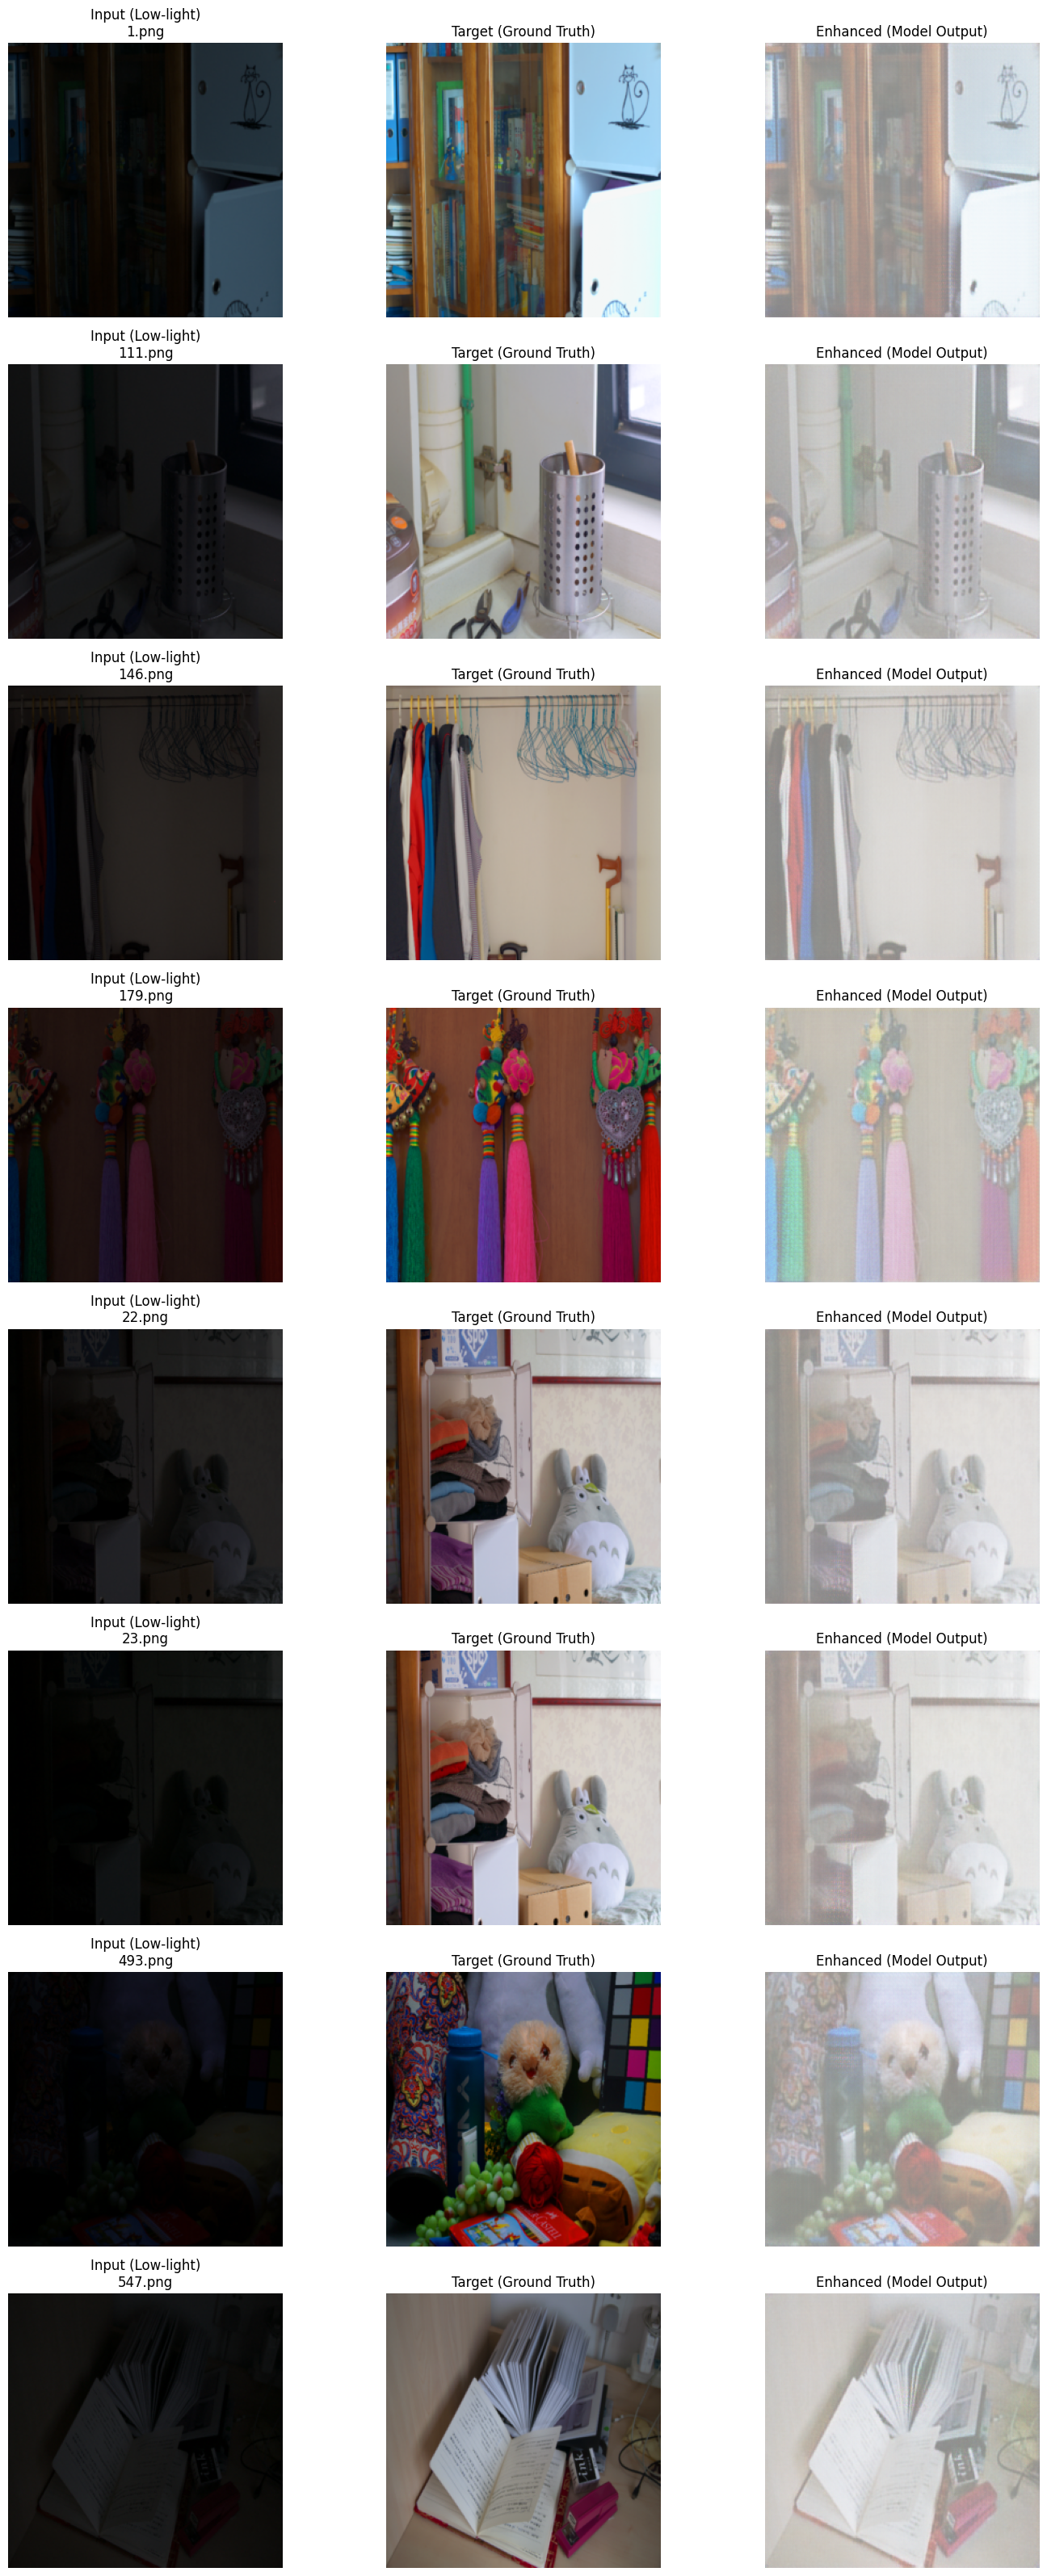

In [ ]:
def visualize_test_results(model, test_loader, device='cuda', num_samples=4):
    """Visualize test results: input, target, and enhanced images"""
    model.eval()

    # Get a batch from test loader
    batch = next(iter(test_loader))

    def denormalize(tensor):
        return tensor * 0.5 + 0.5

    # Select samples
    indices = range(min(num_samples, len(batch['low'])))

    # Create figure
    fig, axes = plt.subplots(len(indices), 3, figsize=(15, len(indices)*4))
    if len(indices) == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            # Process images
            low_img = batch['low'][idx].unsqueeze(0).to(device)
            high_img = batch['high'][idx].unsqueeze(0).to(device)
            enhanced_img = model.enhance(low_img)

            # Convert and denormalize
            low_img = denormalize(low_img.squeeze(0).cpu().permute(1, 2, 0)).numpy()
            high_img = denormalize(high_img.squeeze(0).cpu().permute(1, 2, 0)).numpy()
            enhanced_img = denormalize(enhanced_img.squeeze(0).cpu().permute(1, 2, 0)).numpy()

            # Plot
            for j, (img, title) in enumerate(zip(
                [low_img, high_img, enhanced_img],
                ["Input (Low-light)", "Target (Ground Truth)", "Enhanced (Model Output)"]
            )):
                axes[i,j].imshow(np.clip(img, 0, 1))
                axes[i,j].set_title(f"{title}\n{batch['filename'][idx]}" if j==0 else title)
                axes[i,j].axis('off')

    plt.tight_layout()
    plt.show()

# Usage with safe loading
if __name__ == '__main__':
    train_loader, val_loader, test_loader = setup_data(batch_size=8)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = LowLightGAN(device=device).to(device)

    checkpoint_path = 'checkpoints/best_model.pth'
    if os.path.exists(checkpoint_path):
        try:
            # Try secure loading first
            checkpoint = torch.load(checkpoint_path, map_location=device)
        except:
            # Fallback to weights_only=False if needed
            checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

        model.load_state_dict(checkpoint['model_state'])
        print("Loaded trained model weights")

    visualize_test_results(model, test_loader, device=device, num_samples=15)